# <h1><center> **Universidad Nacional Autonoma de México.** </center></h1>
# <h3><center> **Facultad de Estudios Superiores Acatlán.** </center></h3>
# <h4><center> **Actuaria.** </center></h4>
# <h3><center>*Analisis de Regresión.*</center></h3>
---

# <center> *Tarea #3 (Equipo 2)* </center>

---
**Integrantes:**

  * Mendieta Lopez David - - - - - - > 317231186
  * López Ascencio Guadalupe - - - - - - > 317327337
  * Orozpe Frias Erick Adrián - - - - - - > 318361697
  * Quistian López María Fernanda - - - - - - > 317231186
  * Rodríguez Teodores Armando Jair - - - - - - > 318118501

# **Notas del Profesor**
Buen trabajo, falto elaborar más en la descripción del dataset

La recomendación es no usar este dataset para el trabajo final.

Calificaciòn: 9.5

# Regresión Logística

## Pasos
1. Descripción del dataset
2. Cargar el dataset
3. Proporción de la variable objetivo
4. Revisar valores vacíos
5. Revisar valores infinitos

6. Gráficos. Algunas opciones son:
  * Gráfico de barras
  * Histograma
  * Distribución
  * Boxplot
7. Selección de variables

8. Revisar multicolinealidad

  a. VIF

9. Revisión del modelo

  a. Summary

  b. Curva ROC

  c. Matriz de confusión

## Librerías

In [ ]:
# Análisis
import pandas as pd
import numpy as np
import scipy as sp

# Gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# Solicitud a sitios web
import requests
from io import BytesIO

# Modelo de regresión logística y métricas para revisar la precisión de predicción de nuestro modelo
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report,  auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
# statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif


from imblearn.over_sampling import SMOTE


## Funciones

In [ ]:
def check_vacios(data: pd.DataFrame):

  vacios = pd.Series({x: data[x].isnull().sum() for x in data.columns}, name="vacíos")
  if vacios.sum() > 0:
    subset = vacios[vacios > 0]
    print("El dataset contiene valores vacíos", "\n")
    print(vacios[vacios > 0])
    return {col: data[data[col].isna()].loc[:, [col]] for col in subset.index} # diccionario que contiene la columna y el subset de los datos que contiene los valores vacíos
  else:
    print("No hay nulos en ninguna columna")
    return None

In [ ]:
def check_infs(data: pd.DataFrame):
  infs = pd.Series({x: np.isinf(data[x]).sum() for x in data.select_dtypes(include=["float64"]).columns}, name="infitos")
  if infs.sum() > 0:
    subset = infs[infs > 0]
    print("El dataset contiene valores infinitos", "\n")
    print(subset)
    return {col: data[np.isinf(data[col])].loc[:, [col]] for col in subset.index} # diccionario que contiene la columna y el subset de los datos que contiene los valores infinitos
  else:
    print("No hay valores infinitos en ninguna columna")
    return None

In [ ]:
def average_BR(data: pd.DataFrame, groupby: str, target: str):
  return data.groupby(by=groupby)[target].sum()/data.groupby(by=groupby)[target].count()

In [ ]:
def proportion(data: pd.DataFrame, groupby: str, target: str):
  return data.groupby(by=groupby)[target].count()/data[target].__len__()

In [ ]:
def plot_avg_prop(data: pd.DataFrame, groupby: str, target: str, color: str, sortby=None):
  # Medidas
  avg_BR = average_BR(data=data, groupby=groupby, target=target)
  prop = proportion(data=data, groupby=groupby, target=target)

  # Tabla auxiliar
  table = pd.concat([prop, avg_BR], axis=1)
  table.columns = ["prop_n_obs", "avg_BR"]
  if sortby:
    table.sort_values(by=sortby, ascending=True, inplace=True)

  # Gráfico
  index = [str(x) for x in table.index]
  plt.figure(figsize = (15, 5))
  sns.lineplot(data=table, x=index, y="avg_BR", linestyle="--", marker="o", color="k")
  sns.barplot(data=table, x=index, y="prop_n_obs", color=color)

  # # Define el nombre del eje X
  plt.xlabel(groupby)
  # Define el nombre del eje Y
  plt.ylabel('Average BR')
  # Define el título del gráfico
  plt.title(f"Average BR by {groupby}")

  plt.show()

In [ ]:
def plot_bar(data: pd.DataFrame, columna: str, width: int = 20, height: int = 3, sep=False):
  plt.figure(figsize=(width, height))
  data[columna].value_counts().sort_index().plot(kind='bar')
  plt.show()

  if sep:
    print()

In [ ]:
def create_dummies(data: pd.DataFrame):
  data_with_dummies = data.copy()
  varscat = data.select_dtypes(include=["object", "category"]).columns.tolist() # convertir columnas de tipo object o categóricas a dummies
  for col in varscat:
    n = data[col].unique().__len__()
    if n == 2:
      dummies = pd.get_dummies(data[col], drop_first=True, prefix=col, dtype=int)
    elif n > 2:
      i = int(n/2)
      drop_col = data[col].value_counts().index.tolist()[i]
      dummies = pd.get_dummies(data[col], prefix=col, dtype=int).drop(f"{col}_{drop_col}", axis=1)
    else:
      continue

    data_with_dummies = pd.concat([data_with_dummies, dummies], axis=1)
    data_with_dummies.drop(col, axis=1, inplace=True)

  return data_with_dummies

In [ ]:
def selectby_vif(data: pd.DataFrame, target: str, tolerancia: int):
  columns = [x for x in data.columns if x != target]
  constant = sm.add_constant(data.loc[:, columns])
  resultados = [(constant.columns[i], vif(constant.values, i))
                for i in range(1, constant.shape[1])
                if vif(constant.values, i) < tolerancia]

  keep_columns = [x[0] for x in resultados]

  return data.loc[:, keep_columns+[target]].copy()

## Dataset (ds_04032021.csv)

### Descripción del dataset
El siguiente dataset recolectado de una Fintech, contiene información de datos de clientes que adquirienron un crédito.

Objetivo del proyecto: Pronosticar con base en la información de trancciones  si un cliente va a pagar el crédito en los proximos 30 días (target 0) o si no va a pagar (target 1)

Descripción de las columnas principales:

| Column | Description |
|--------|-------------|
| gender | Female o male |
| state_group | Región geográfica |
| Age | Edad del cliente|
| disbursement_date | Fecha de deposito en la cuenta del cliente |
| output | Pago correcto del prestamo después de 30 días |
| COUNT(transactions1to30days_purchase) | conteo de las transacciones entre 1 y 30 días de compra |
| SUM(transactions1to30days_purchase.amount) | Suma de las transacciones entre 1 y 30 días de compra  |
| MEAN(transactions1to30days_purchase.amount) |Promedio de las transacciones entre 1 y 30 días de compra |
| COUNT(transactions31to60days_cableOut) | Conteo de transacciones entre 31 y 60 días de salida hacia otro banco (mismo país)|
| SUM(transactions31to60days_cableOut) | Suma de transacciones entre 31 y 60 días de salida hacia otro banco (mismo país) |
| MEAN(transactions31to60days_cableOut) | Promedio de transacciones entre 31 y 60 días de salida hacia otro banco (mismo país)  |
| ratioCableInOut_Into30days | Proporción entre transacciones de entrada y salida de 1 a 30 días |
| ratioBalanceIn_1to30days| Balance de recepción de dinero que tuvo el cliente en 30 días |

### Cargar el dataset

In [ ]:
ds = pd.read_csv("https://raw.githubusercontent.com/ericku2101/regresion_logistica/main/ds_04032021.csv")

In [ ]:
print(ds.shape) # Dimensión de los datos

(2925, 45)


In [ ]:
display(ds.head())

,user_id,gender,state_group,age,output,COUNT(transactions1to30days_purchase),SUM(transactions1to30days_purchase.amount),MEAN(transactions1to30days_purchase.amount),COUNT(transactions31to60days_purchase),SUM(transactions31to60days_purchase.amount),...,MEAN(transactionsDaily1to30days_purchase.amount),MEAN(transactionsDaily31to60days_purchase.amount),MEAN(transactionsDaily1to30days_clabeOut.amount),MEAN(transactionsDaily31to60days_clabeOut.amount),MEAN(transactionsDaily1to30days_clabeInc.amount),MEAN(transactionsDaily31to60days_clabeInc.amount),MEAN(transactionsDaily1to30days_atm.amount),MEAN(transactionsDaily31to60days_atm.amount),disbursement_date,month
0,008bad4a-e16b-4e6e-b086-20550bc23799,MALE,south_mexico,49,False,8,3094.0,386.750,25,3216.00,...,430.500,110.750,381.250,396.00,890.00,564.5,0.0,0.0,2020-12-11,202012
1,0097365c-b2cb-4a5c-acb5-de3be46a8e8e,MALE,central_mexico,29,True,3,302.0,100.625,0,0.00,...,112.000,0.000,189.625,13.00,500.00,255.5,0.0,0.0,2020-12-31,202012
2,01a061b9-dc93-45db-8b42-3eb7ef0f5b2c,MALE,south_mexico,49,True,14,3540.0,252.750,23,3516.00,...,311.750,148.375,713.500,323.25,793.00,564.0,1147.0,863.0,2020-12-11,202012
3,01fd4e8b-b332-4277-8903-6a73b77be436,MALE,south_mexico,54,True,22,1963.0,89.188,12,814.50,...,87.625,60.844,117.125,486.50,259.25,694.0,0.0,696.5,2020-12-11,202012
4,02dd280b-046c-4f2f-8351-f1ec1d481e16,MALE,pacific,34,False,2,1115.0,557.500,5,257.25,...,557.500,57.625,0.000,0.00,0.00,630.0,0.0,0.0,2020-12-11,202012


In [ ]:
print(ds.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2925 entries, 0 to 2924
Data columns (total 45 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   user_id                                            2925 non-null   object 
 1   gender                                             2925 non-null   object 
 2   state_group                                        2925 non-null   object 
 3   age                                                2925 non-null   int64  
 4   output                                             2925 non-null   bool   
 5   COUNT(transactions1to30days_purchase)              2925 non-null   int64  
 6   SUM(transactions1to30days_purchase.amount)         2925 non-null   float64
 7   MEAN(transactions1to30days_purchase.amount)        2925 non-null   float64
 8   COUNT(transactions31to60days_purchase)             2925 non-null   int64  
 9   SUM(tran

In [ ]:
# Borramos columnas que no vamos a ocupar
delete_columns = ["user_id", "disbursement_date", "month"]
ds.drop(delete_columns, axis=1, inplace=True)

In [ ]:
y = "output" # variable objetivo
ds[y] = ds[y].apply(lambda x: 1 if x else 0)

## Proporción de la variable objetivo

output
0    0.708718
1    0.291282
Name: proportion, dtype: float64

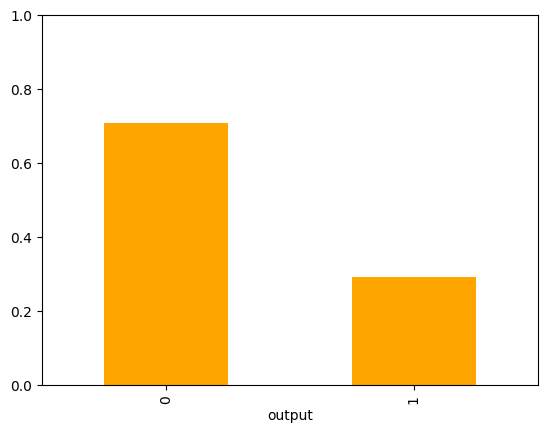

In [ ]:
display(ds[y].value_counts(normalize=True))
print()
ds[y].value_counts(normalize=True).plot(kind="bar", color="orange", ylim=(0,1))
plt.show()

Como vemos la proporción de nuestra variable objetivo es aceptable al ser del 30% entonces hemos tomado la decisión de no hacer un sobremuestreo.

### Valores Nulos

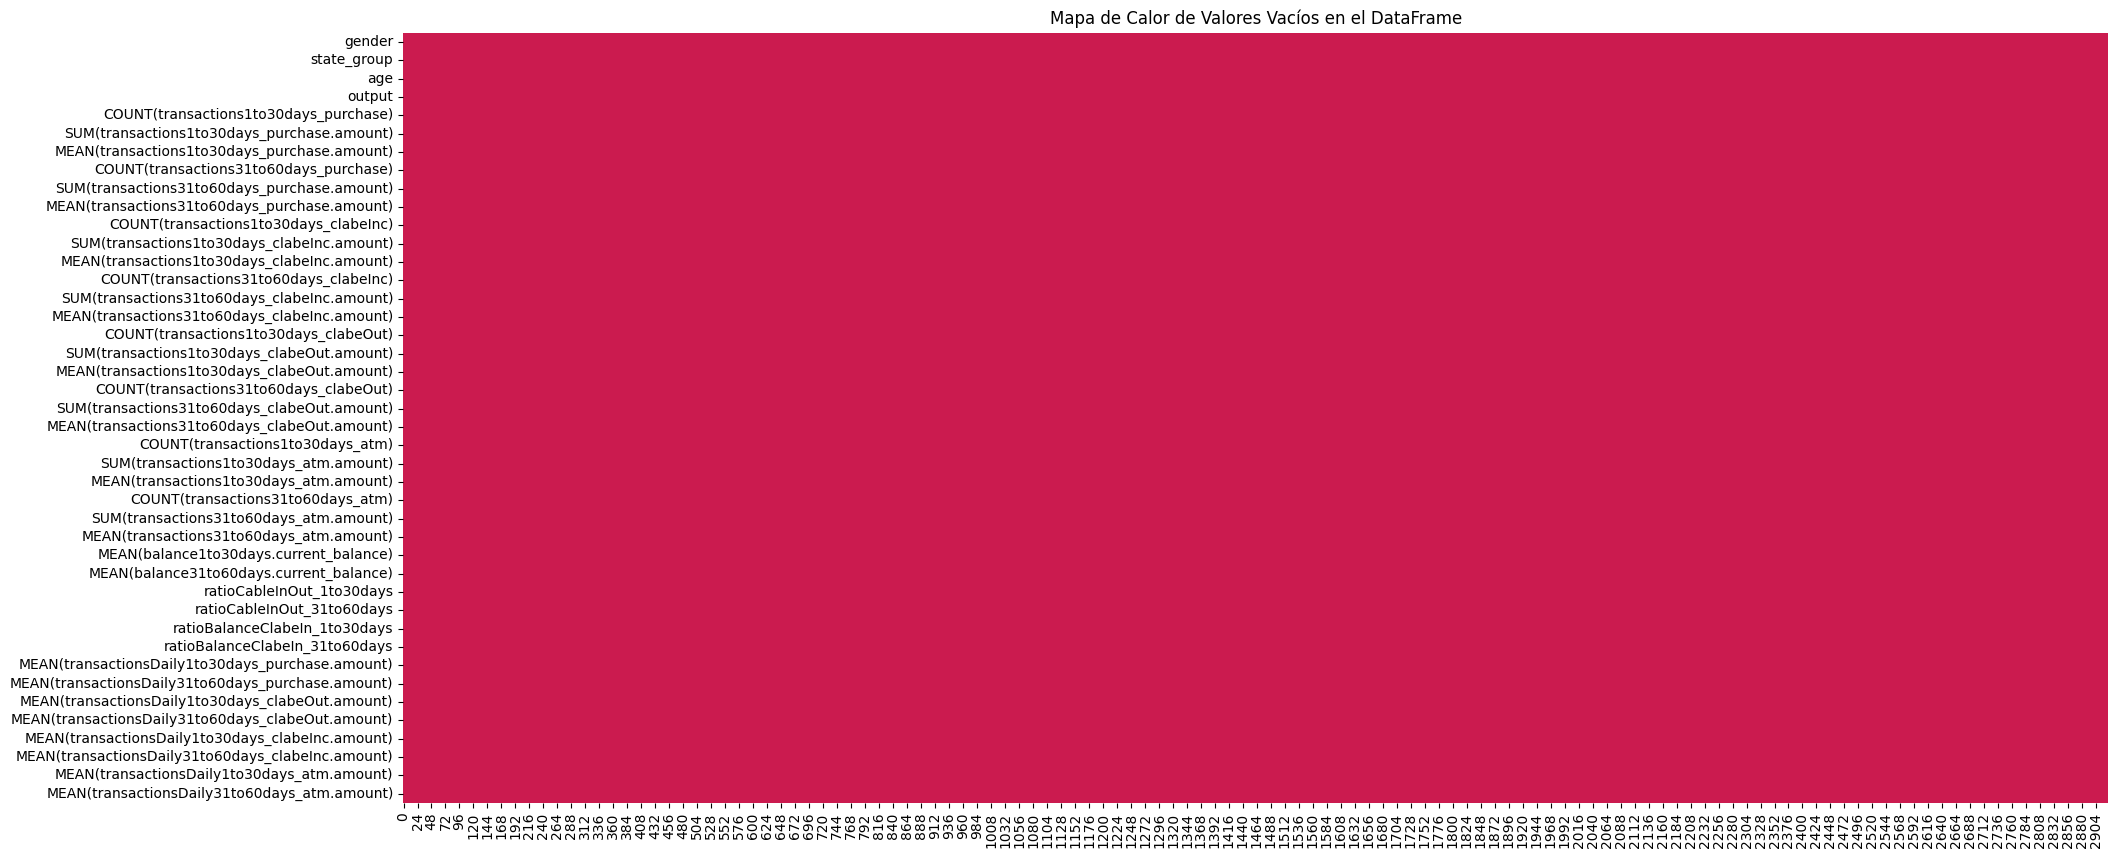

In [ ]:
# Usar seaborn para crear un mapa de calor
plt.figure(figsize=(22, 10))
sns.heatmap(ds.isnull().T, cbar=False, vmin=-1, vmax=1)
plt.title('Mapa de Calor de Valores Vacíos en el DataFrame')
plt.show()


In [ ]:
# Valores nulos por columna
vacios = check_vacios(data=ds)

No hay nulos en ninguna columna


### Valores Infinitos

In [ ]:
# Valores infinitos por columna
infs = check_infs(data=ds)

El dataset contiene valores infinitos 

SUM(transactions31to60days_purchase.amount)    1
SUM(transactions1to30days_clabeInc.amount)     9
SUM(transactions31to60days_clabeInc.amount)    5
SUM(transactions1to30days_clabeOut.amount)     4
SUM(transactions31to60days_clabeOut.amount)    2
SUM(transactions31to60days_atm.amount)         1
Name: infitos, dtype: int64


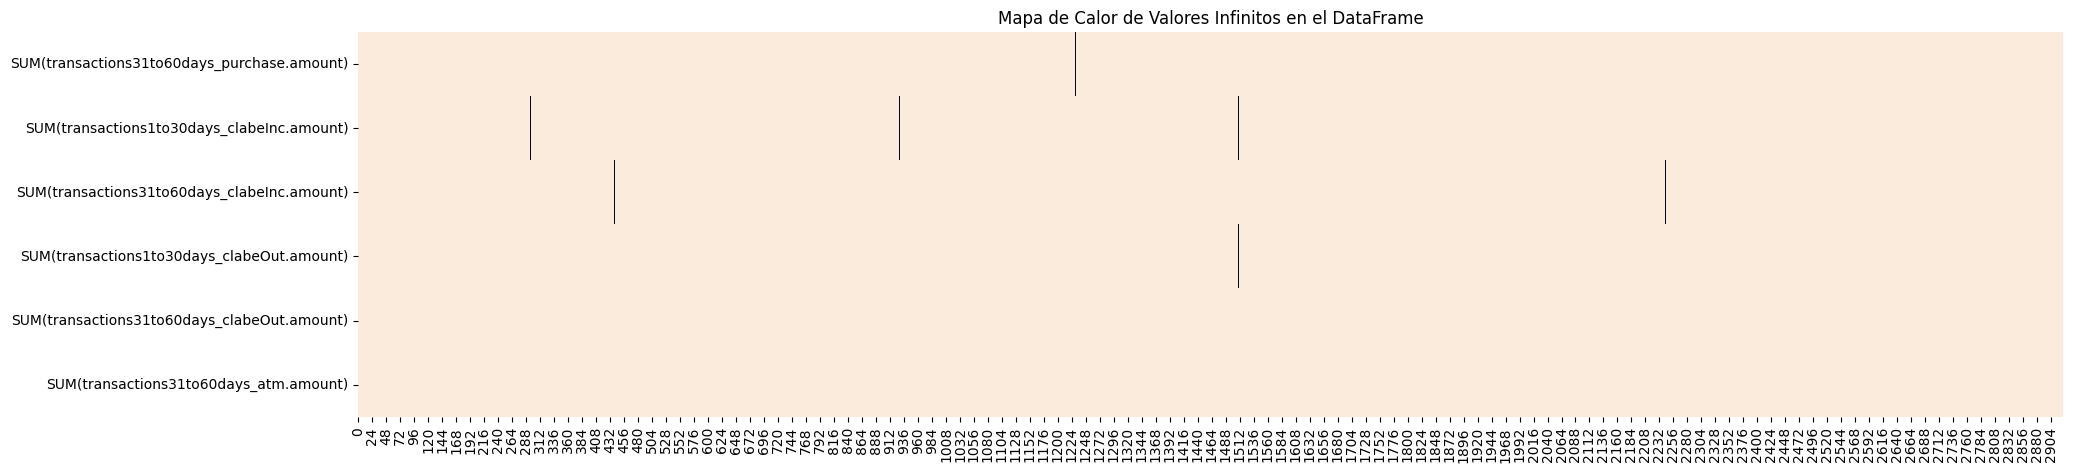

In [ ]:
inf_matrix = pd.concat([~np.isinf(ds[x]) for x in infs.keys()], axis=1)

# Usar seaborn para crear un mapa de calor
plt.figure(figsize=(22, 5))
sns.heatmap(inf_matrix.T, cbar=False)
plt.title('Mapa de Calor de Valores Infinitos en el DataFrame')
plt.show()


In [ ]:
# Podemos ver cuales de las filas contienen infinitos con el diccionario que hemos creado en la celda anterior
display(infs["SUM(transactions31to60days_clabeInc.amount)"])

,SUM(transactions31to60days_clabeInc.amount)
66,inf
439,inf
1243,inf
1921,inf
2242,inf


In [ ]:
for column in infs.keys():
    # Calcula el máximo de la columna excluyendo valores infinitos
    max_value = ds[column].drop(infs[column].index).max()
    # Calcula el mínimo de la columna excluyendo valores infinitos
    min_value = ds[column].drop(infs[column].index).min()
    # Reemplaza los valores infinitos con el máximo y mínimo encontrados
    ds[column].replace(to_replace=[np.inf], value=max_value, inplace=True)
    ds[column].replace(to_replace=[-np.inf], value=min_value, inplace=True)

In [ ]:
# Verificar si aún hay valores infinitos en las columnas ajustadas
infs = check_infs(data=ds)

No hay valores infinitos en ninguna columna


### Gráficos

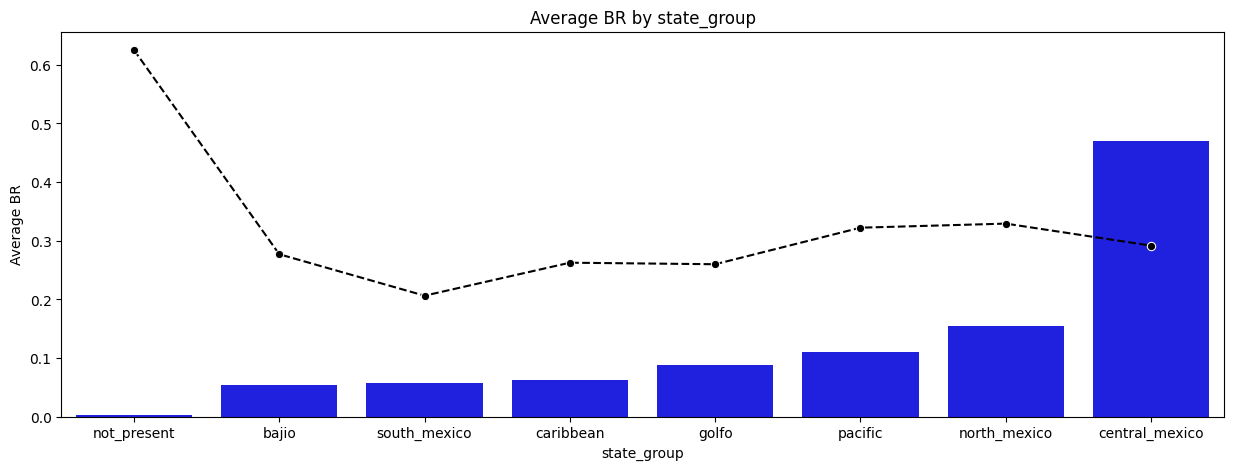

In [ ]:
# Función creada que grafica la proporción y promedio de la columna por la que andamos agrupando la información
plot_avg_prop(data=ds, groupby="state_group", target=y, color="b", sortby="prop_n_obs")

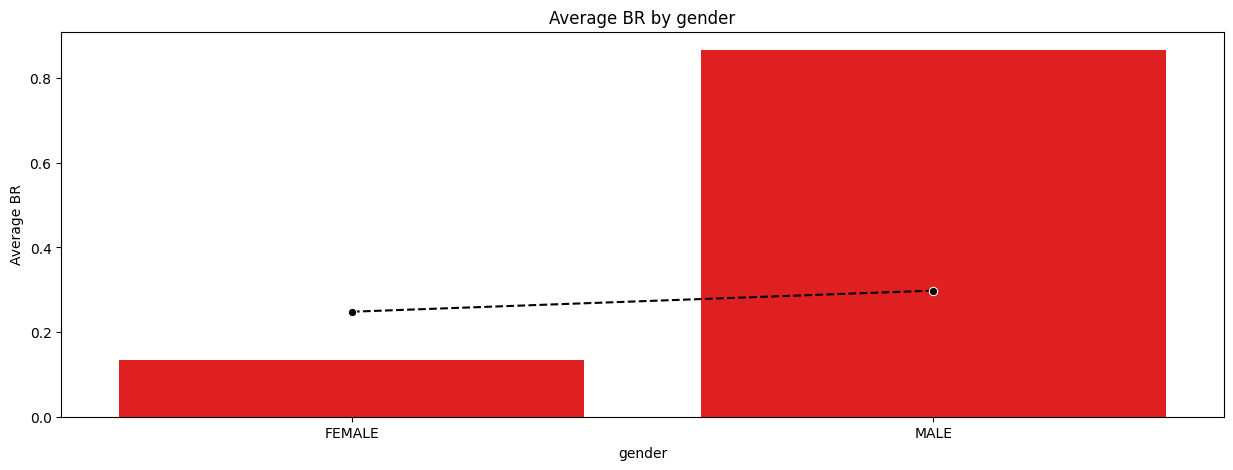

In [ ]:
# Función creada que grafica la proporción y promedio de la columna por la que andamos agrupando la información
plot_avg_prop(data=ds, groupby="gender", target=y, color="r", sortby="prop_n_obs")

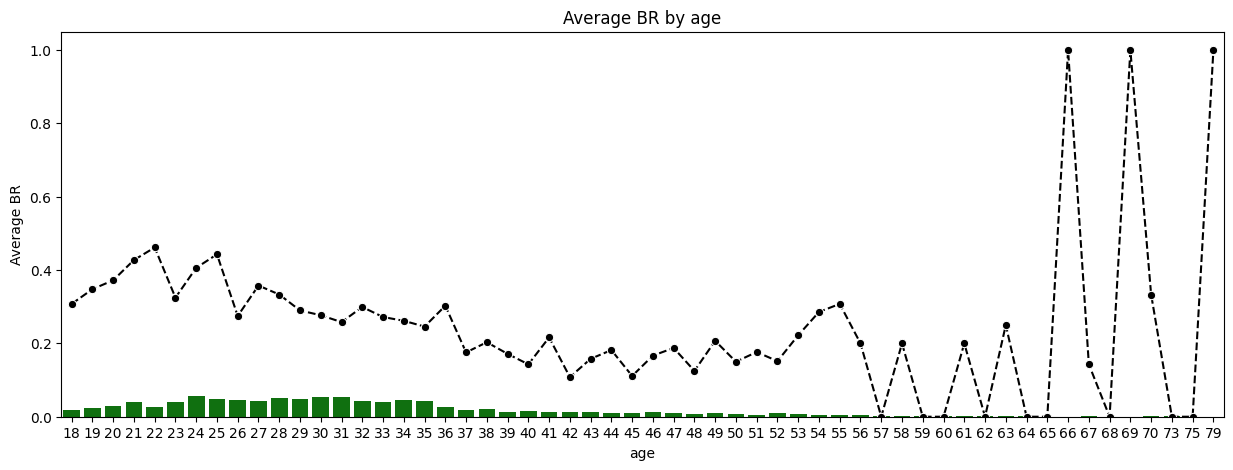

In [ ]:
# Función creada que grafica la proporción y promedio de la columna por la que andamos agrupando la información
plot_avg_prop(data=ds, groupby="age", target=y, color="g")

Documentación qcut
1. https://www.geeksforgeeks.org/how-to-use-pandas-cut-and-qcut/
2. https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html

In [ ]:
edad = ds["age"]

cut_edad5 = pd.cut(edad, bins=5)
cut_edad5.name = "cut_age5"

cut_edad10 = pd.cut(edad, bins=10)
cut_edad10.name = "cut_age10"

quantiles5 = [0, 0.2, 0.4, 0.6, 0.8, 1] # equivalente a quantiles = 5
qcut_edad5 = pd.qcut(edad, q=quantiles5)
qcut_edad5.name = "qcut_age5"

quantiles10 = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] # equivalente a quantiles = 10
qcut_edad10 = pd.qcut(edad, q=quantiles10)
qcut_edad10.name = "qcut_age10"

tabla = pd.concat([edad, cut_edad5, cut_edad10, qcut_edad5, qcut_edad10], axis=1)
display(tabla.head())
print()
print(tabla.info())

,age,cut_age5,cut_age10,qcut_age5,qcut_age10
0,49,"(42.4, 54.6]","(48.5, 54.6]","(38.0, 79.0]","(46.0, 79.0]"
1,29,"(17.939, 30.2]","(24.1, 30.2]","(28.0, 32.0]","(28.0, 30.0]"
2,49,"(42.4, 54.6]","(48.5, 54.6]","(38.0, 79.0]","(46.0, 79.0]"
3,54,"(42.4, 54.6]","(48.5, 54.6]","(38.0, 79.0]","(46.0, 79.0]"
4,34,"(30.2, 42.4]","(30.2, 36.3]","(32.0, 38.0]","(32.0, 34.0]"



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2925 entries, 0 to 2924
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   age         2925 non-null   int64   
 1   cut_age5    2925 non-null   category
 2   cut_age10   2925 non-null   category
 3   qcut_age5   2925 non-null   category
 4   qcut_age10  2925 non-null   category
dtypes: category(4), int64(1)
memory usage: 35.8 KB
None


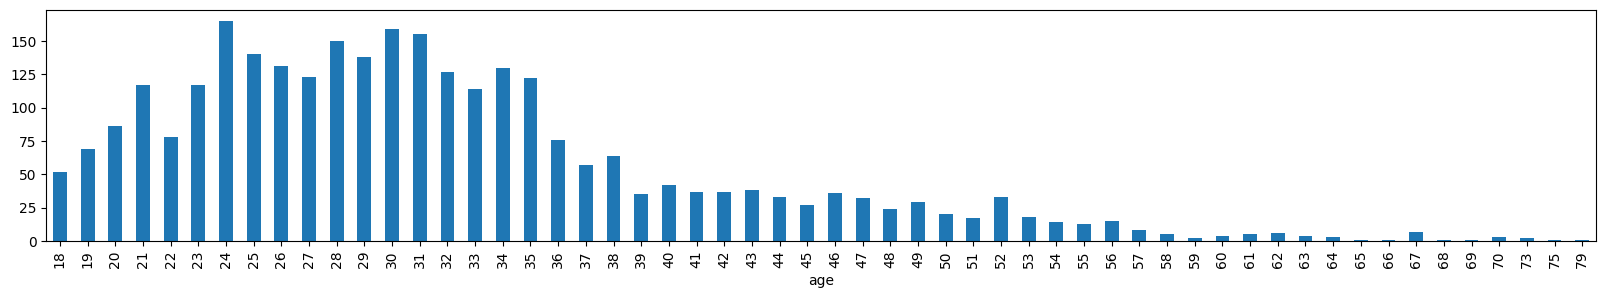

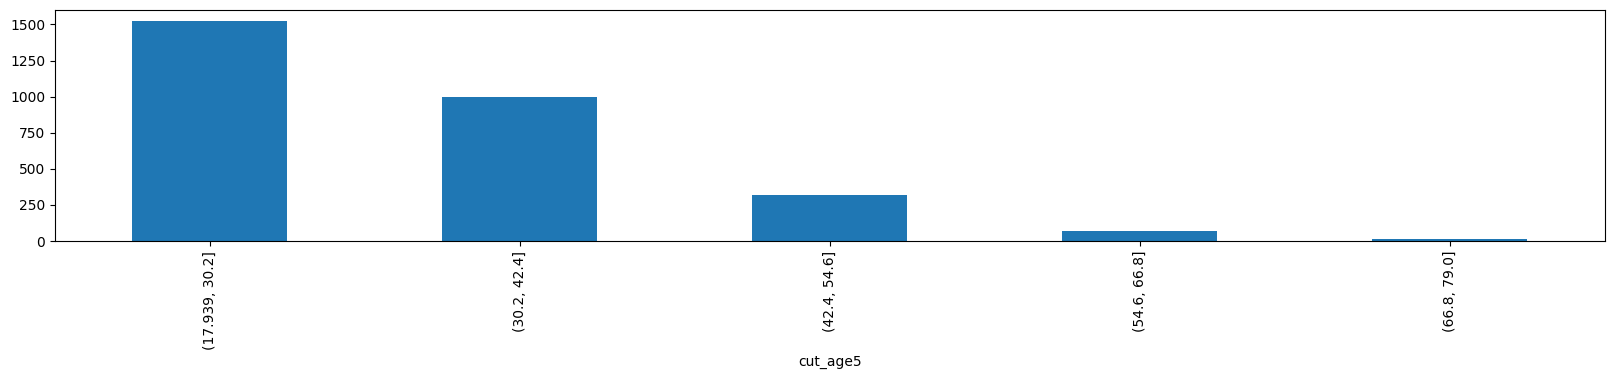

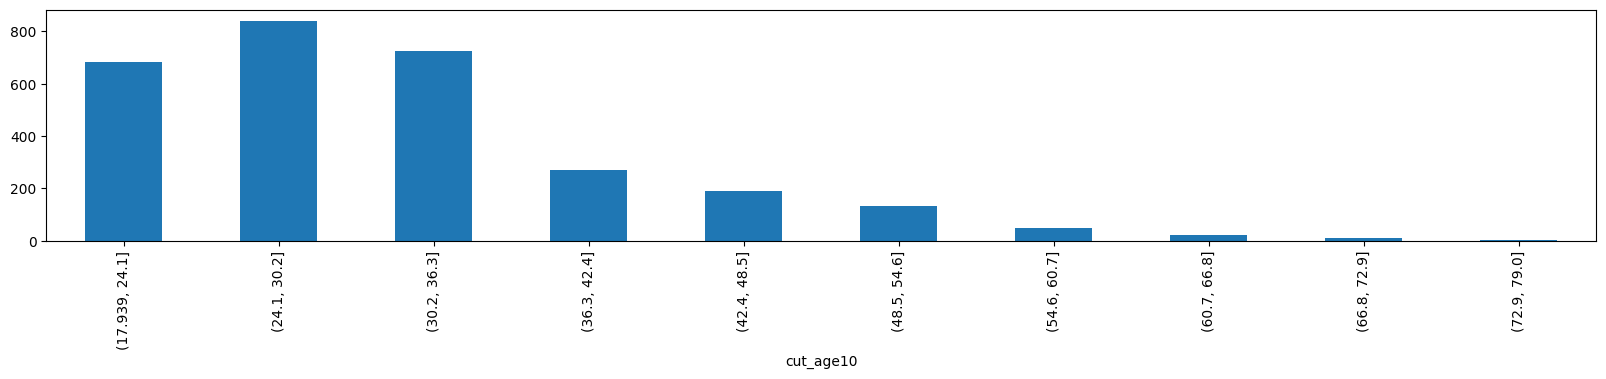

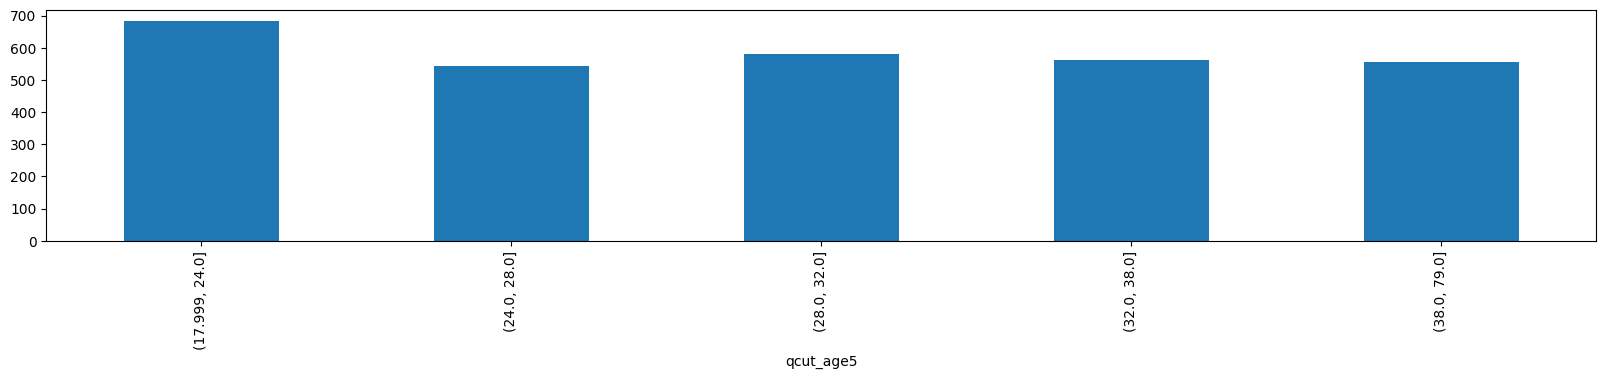

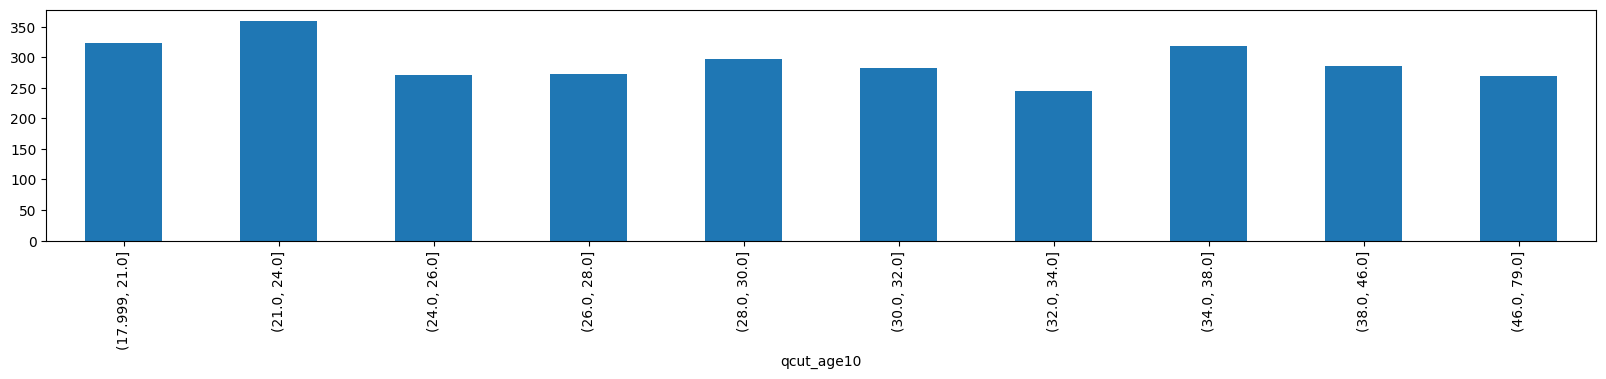

In [ ]:
# Función creada para generar un gráfico de barra de la columna deseada de algún dataframe
plot_bar(data=tabla, columna="age", sep=True) # se agrega el parámetro sep para dejar un salto de línea (default=False) al final del gráfico
plot_bar(data=tabla, columna="cut_age5", sep=True)
plot_bar(data=tabla, columna="cut_age10", sep=True)
plot_bar(data=tabla, columna="qcut_age5", sep=True)
plot_bar(data=tabla, columna="qcut_age10", sep=True)

Lo que podemos notar de pd.qcut a diferencia de pd.cut es que pd.cut divide en partes iguales el intervalo de la edad pero sigue acumulandose la distribución en alguno de los intervalos mientras que pd.qcut distribuye equitativamente la información sin embargo la longitud de los intervalos puede variar.

In [ ]:
pd.DataFrame(ds["age"].describe(percentiles=quantiles10)).T

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%,max
age,2925.0,31.814701,9.546229,18.0,18.0,21.0,24.0,26.0,28.0,30.0,32.0,34.0,38.0,46.0,79.0,79.0


Mantendremos los percentiles como en clase (10 : {0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1})

In [ ]:
ds["age_factor"] = pd.qcut(ds["age"], q=quantiles10)

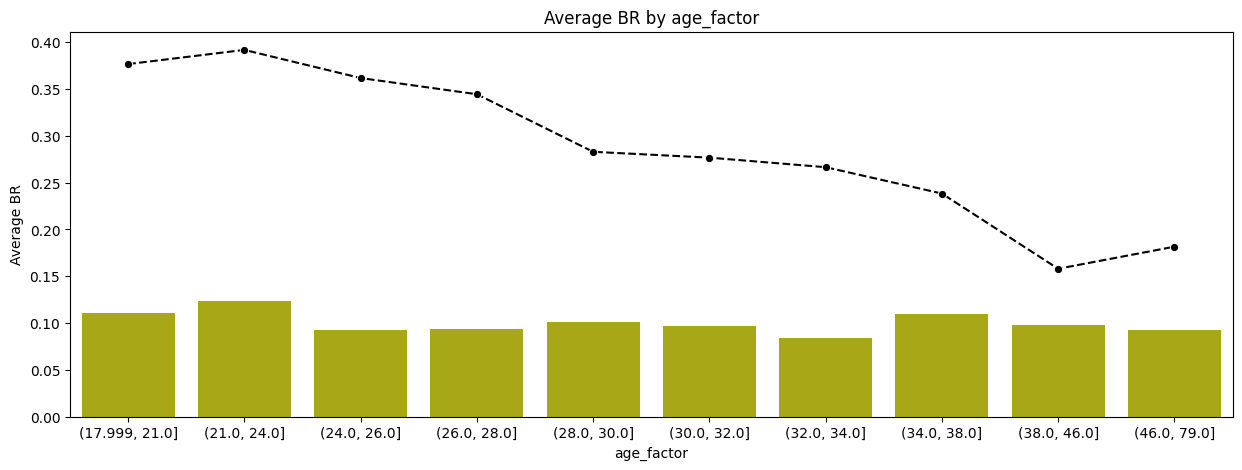

In [ ]:
# Función creada que grafica la proporción y promedio de la columna por la que andamos agrupando la información
plot_avg_prop(data=ds, groupby="age_factor", target=y, color="y")

### Dummies

In [ ]:
# Obtenemos un nuevo dataframe con columnas dummies y sin las columnas que han sido transformadas
ds_with_dummies = create_dummies(ds)
ds_with_dummies.drop("age", axis=1, inplace=True)

In [ ]:
print(ds.shape)
print(ds_with_dummies.shape)

(2925, 43)
(2925, 56)


### Selección de variables

In [ ]:
Y = ds_with_dummies.loc[:, ds_with_dummies.columns == y]
X = ds_with_dummies.loc[:, ds_with_dummies.columns != y]

In [ ]:
# División del conjunto de datos en subconjuntos de entrenamiento y prueba con una proporción de 70/30
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [ ]:
# Creamos un remuestreo para que la variable objetivo esté igualmente proporcionada
over_sample = SMOTE(random_state=0)
os_X, os_Y = over_sample.fit_resample(X_train, Y_train)
os_X = pd.DataFrame(data=os_X, columns=X_train.columns)
os_Y = pd.DataFrame(data=os_Y, columns=[y])

# Podemos revisar los siguientes valores
print("Longitud de la data después del oversample", len(os_X))
print("Número de ceros en la variable objetivo", len(os_Y[os_Y[y]==0]))
print("Número de ceros en la variable objetivo", len(os_Y[os_Y[y]==1]))
print("Proporción de ceros en la variable objetivo", len(os_Y[os_Y[y]==0])/len(os_X))
print("Proporción de ceros en la variable objetivo", len(os_Y[os_Y[y]==1])/len(os_X))

Longitud de la data después del oversample 2880
Número de ceros en la variable objetivo 1440
Número de ceros en la variable objetivo 1440
Proporción de ceros en la variable objetivo 0.5
Proporción de ceros en la variable objetivo 0.5


In [ ]:
ds_with_dummies = pd.concat([os_X, os_Y], axis=1)

In [ ]:
# Features
rfe = RFE(estimator=LogisticRegression())
rfe.fit(os_X, os_Y.values.ravel())

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

RFE(estimator=LogisticRegression())

In [ ]:
representativas = os_X.columns[rfe.support_]

In [ ]:
print(len(representativas), "variables representativas")

27 variables representativas


### Modelo

In [ ]:
X = os_X.loc[:, representativas]
Y = os_Y

In [ ]:
# División del conjunto de datos en subconjuntos de entrenamiento y prueba con una proporción de 70/30
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [ ]:
logit_model = sm.Logit(Y, X) # statmodels

result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.577429
         Iterations 8
                                         Results: Logit
Model:                         Logit                      Method:                     MLE        
Dependent Variable:            output                     Pseudo R-squared:           0.167      
Date:                          2024-05-05 04:12           AIC:                        3379.9925  
No. Observations:              2880                       BIC:                        3541.0623  
Df Model:                      26                         Log-Likelihood:             -1663.0    
Df Residuals:                  2853                       LL-Null:                    -1996.3    
Converged:                     1.0000                     LLR p-value:                7.4605e-124
No. Iterations:                8.0000                     Scale:                      1.0000     
----------------------------------------------------------

In [ ]:
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

conf_matrix = confusion_matrix(Y_test, Y_pred)

TP = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TN = conf_matrix[1, 1]

accuracy = (TP+TN)/(TP+FP+FN+TN)

print(conf_matrix)

print("Precisión del modelo:", accuracy.round(4))

print(classification_report(Y_test, Y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[273 172]
 [126 293]]
Precisión del modelo: 0.6551
              precision    recall  f1-score   support

           0       0.68      0.61      0.65       445
           1       0.63      0.70      0.66       419

    accuracy                           0.66       864
   macro avg       0.66      0.66      0.65       864
weighted avg       0.66      0.66      0.65       864



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


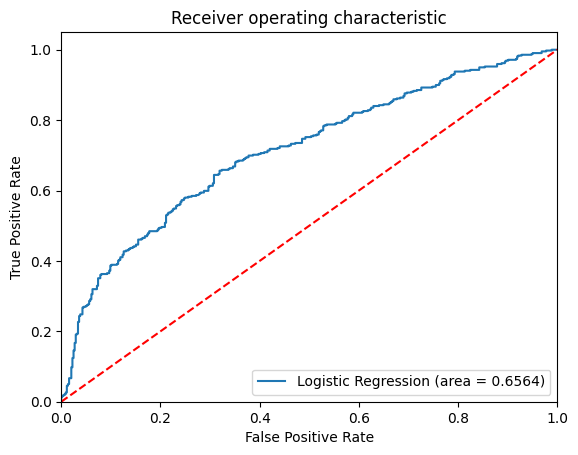

In [ ]:
logit_roc_auc = roc_auc_score(Y_test, logreg.predict(X_test))

fpr, tpr, thresholds = roc_curve(Y_test, logreg.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.4f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')

plt.show()

## Dataset (framingham.csv)

### Descripción del dataset

Descripción de las columnas principales:

| Columna | Descripción |
|--------|-------------|
| Sexo | Masculino o femenino (Nominal) |
| Edad | Edad del paciente (continua) |
| Fumador actual | Si el paciente es fumador actual o no (Nominal) |
| Cigarrillos por día | El número de cigarrillos que la persona fumó en promedio en un día. (Se puede considerar continuo ya que se puede consumir cualquier número de cigarrillos, incluso medio cigarrillo) |

### Cargar el dataset

In [ ]:
framingham = pd.read_csv("https://raw.githubusercontent.com/ericku2101/regresion_logistica/main/framingham.csv")

In [ ]:
framingham

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,1,50,1.0,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1
4234,1,51,3.0,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0
4235,0,48,2.0,1,20.0,NaN,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4236,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,NaN,0


In [ ]:
framingham.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB


In [ ]:
y = "TenYearCHD" # variable objetivo

In [ ]:
framingham.groupby('TenYearCHD').mean() #Calcular la media de cada columna para cada valor de "TenYearCHD" que sería nuestra variable objetivo


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
TenYearCHD,,,,,,,,,,,,,,,
0,0.410684,48.767668,2.002282,0.489983,8.710401,0.023367,0.003895,0.275737,0.019199,235.172530,130.333612,82.160963,25.673007,75.762382,80.682125
1,0.532609,54.145963,1.848726,0.517081,10.629283,0.064771,0.017081,0.504658,0.062112,245.388976,143.618789,86.981366,26.531451,76.530327,89.008418


<ipython-input-93-5f738750c943>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='TenYearCHD', data=framingham, palette=colors)
<ipython-input-93-5f738750c943>:7: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.countplot(x='TenYearCHD', data=framingham, palette=colors)


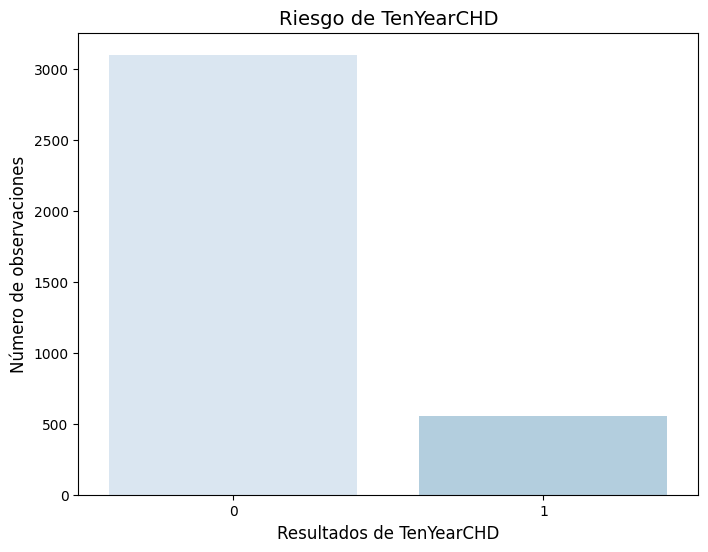

In [ ]:
#Dimensiones de la gráfica
plt.figure(figsize=(8, 6))

# Definir una paleta de colores
colors = sns.color_palette("Blues", 5)  # Puedes elegir la paleta que desees
#Crear grafica
sns.countplot(x='TenYearCHD', data=framingham, palette=colors)
#Añadir titulo y etiqueta a los ejes
plt.title('Riesgo de TenYearCHD', fontsize=14)
plt.xlabel('Resultados de TenYearCHD', fontsize=12)
plt.ylabel('Número de observaciones', fontsize=12)
#Mostrar gráfica
plt.show()


TenYearCHD
0    0.848042
1    0.151958
Name: proportion, dtype: float64

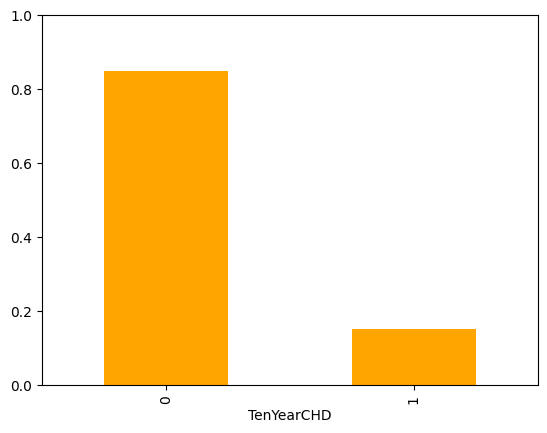

In [ ]:
display(framingham[y].value_counts(normalize=True))
print()
framingham[y].value_counts(normalize=True).plot(kind="bar", color="orange", ylim=(0,1))
plt.show()

<ipython-input-51-caed3435b53c>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='male', data=framingham, palette=colors)
<ipython-input-51-caed3435b53c>:7: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.countplot(x='male', data=framingham, palette=colors)


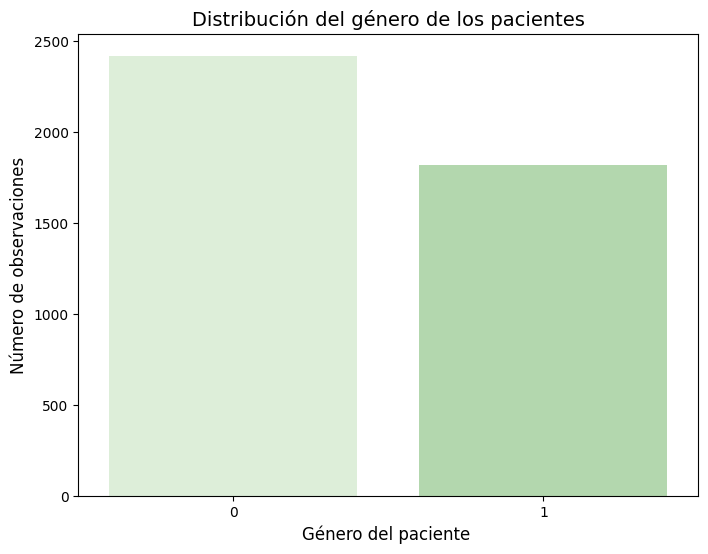

In [ ]:
#Dimensiones de la gráfica
plt.figure(figsize=(8, 6))

# Definir una paleta de colores
colors = sns.color_palette("Greens", 5)
#Crear gráfica
sns.countplot(x='male', data=framingham, palette=colors)
#Añadir títulos y etiquetas a lso ejes
plt.title('Distribución del género de los pacientes', fontsize=14)
plt.xlabel('Género del paciente ', fontsize=12)
plt.ylabel('Número de observaciones', fontsize=12)
#Mostrar gráfica
plt.show()

<ipython-input-94-38f783a42581>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cigsPerDay', data=framingham, palette=colors)
<ipython-input-94-38f783a42581>:7: UserWarning: 
The palette list has fewer values (5) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x='cigsPerDay', data=framingham, palette=colors)


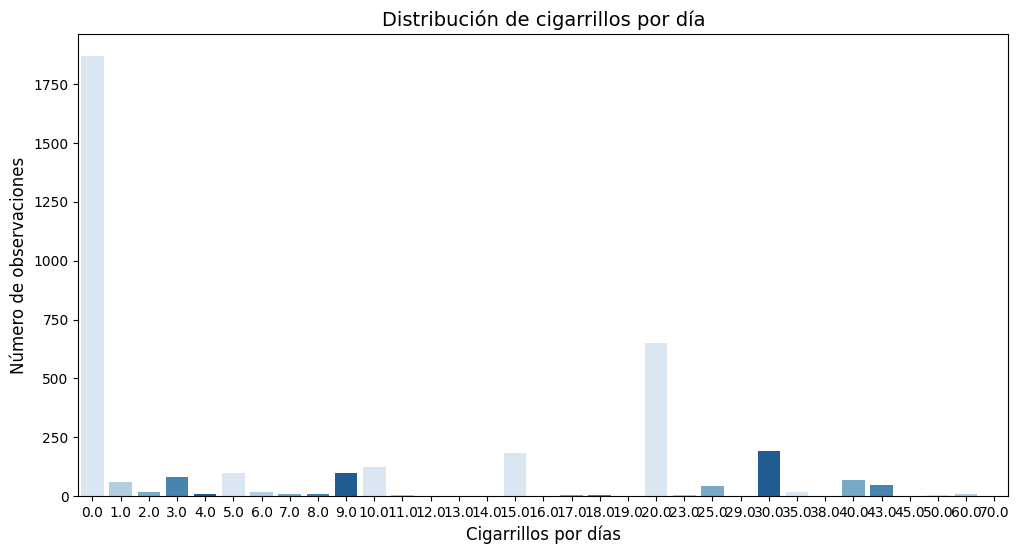

In [ ]:
#Dimensiones de la gráfica
plt.figure(figsize=(12, 6))

# Definir una paleta de colores
colors = sns.color_palette("Blues", 5)
#Crear gráfica
sns.countplot(x='cigsPerDay', data=framingham, palette=colors)
#Añadir títulos y etiquetas a lso ejes
plt.title('Distribución de cigarrillos por día', fontsize=14)
plt.xlabel('Cigarrillos por días', fontsize=12)
plt.ylabel('Número de observaciones', fontsize=12)
#Mostrar gráfica
plt.show()



<ipython-input-95-6c8f760ece1a>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='glucose', data=framingham, palette=colors)
<ipython-input-95-6c8f760ece1a>:7: UserWarning: 
The palette list has fewer values (5) than needed (138) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x='glucose', data=framingham, palette=colors)


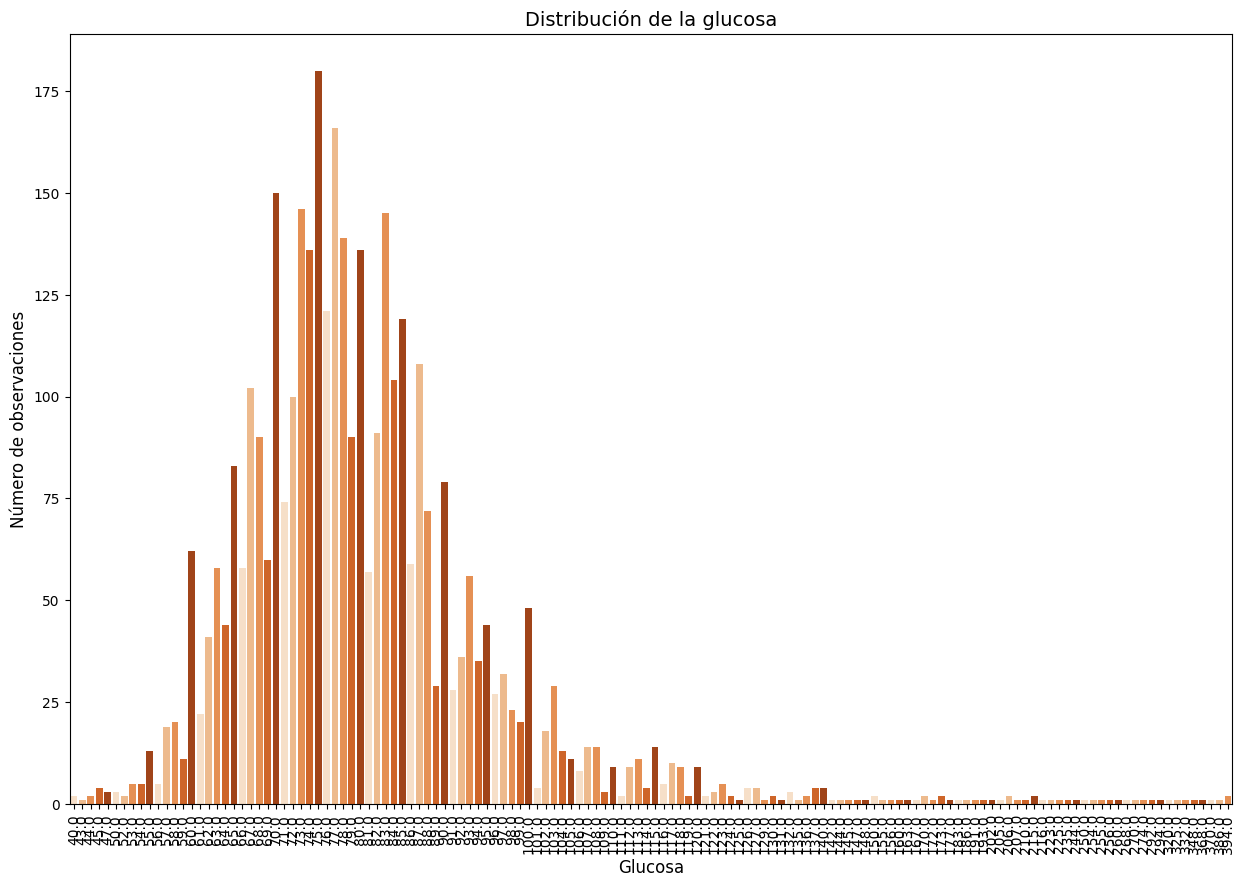

In [ ]:
#Dimensiones de la gráfica
plt.figure(figsize=(15, 10))

# Definir una paleta de colores
colors = sns.color_palette("Oranges", 5)
#Crear gráfica
sns.countplot(x='glucose', data=framingham, palette=colors)
#Añadir títulos y etiquetas a lso ejes
plt.title('Distribución de la glucosa', fontsize=14)
plt.xlabel('Glucosa', fontsize=12)
plt.ylabel('Número de observaciones', fontsize=12)
plt.xticks(rotation=90)
#Mostrar gráfica
plt.show()


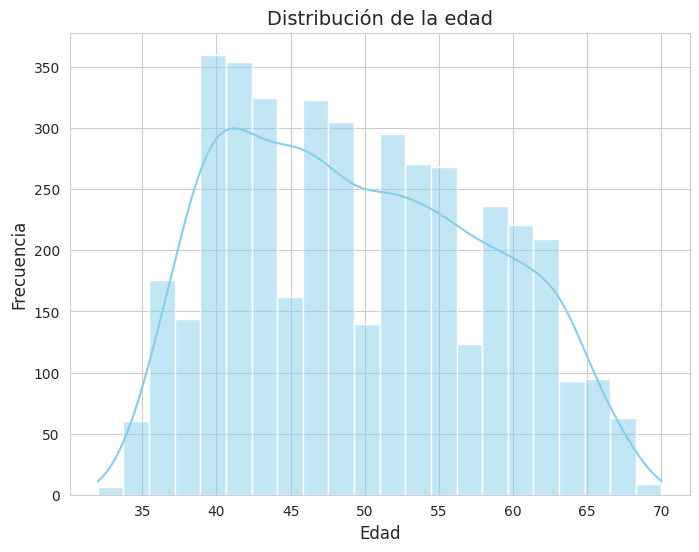

In [ ]:
#Histogramas
#Elegir un estilo
sns.set_style('whitegrid')

#Dimensiones del histograma
plt.figure(figsize=(8,6))
#Crear histograma
sns.histplot(data=framingham, x='age', color='skyblue', kde=True)
# Añadir títulos y etiquetas a los ejes
plt.title('Distribución de la edad', fontsize=14)
plt.xlabel('Edad', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.show()

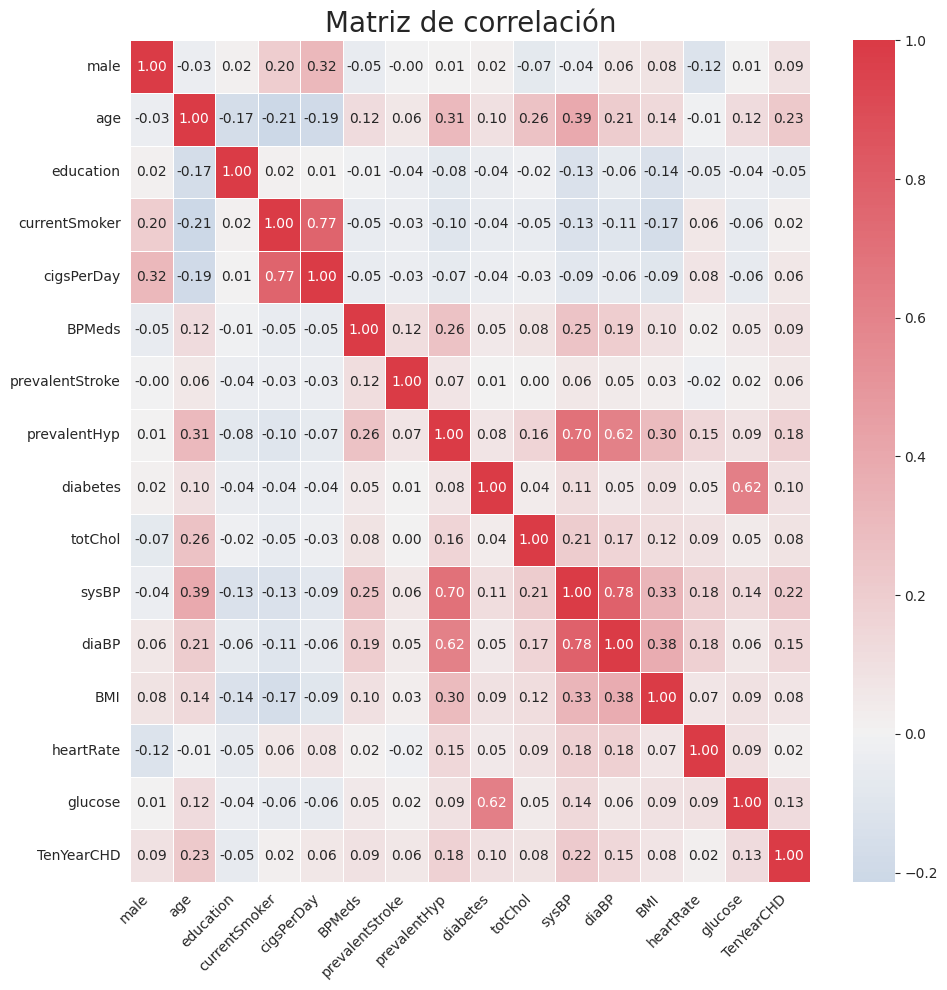

In [ ]:
# Calcular la matriz de correlación
corr_matrix = framingham.corr()

# Configurar la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Matriz de correlación",  fontsize=20)

# Dibujar la matriz de correlación en una tabla con tonos de azul y rojo
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr_matrix, cmap=cmap, center=0, linewidths=0.5, annot=True, fmt=".2f", ax=ax)

# Ajustar las etiquetas de los ejes y el tamaño de la fuente
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=10)

# Mostrar la figura
plt.tight_layout()
plt.show()




In [ ]:
vacios = check_vacios(framingham)

El dataset contiene valores vacíos 

education     105
cigsPerDay     29
BPMeds         53
totChol        50
BMI            19
heartRate       1
glucose       388
Name: vacíos, dtype: int64


In [ ]:
framingham.shape

(4238, 16)

In [ ]:
framingham.dropna(inplace=True) # Eliminamos vacíos

In [ ]:
vacios = check_vacios(framingham)

No hay nulos en ninguna columna


In [ ]:
infs = check_infs(framingham)

No hay valores infinitos en ninguna columna


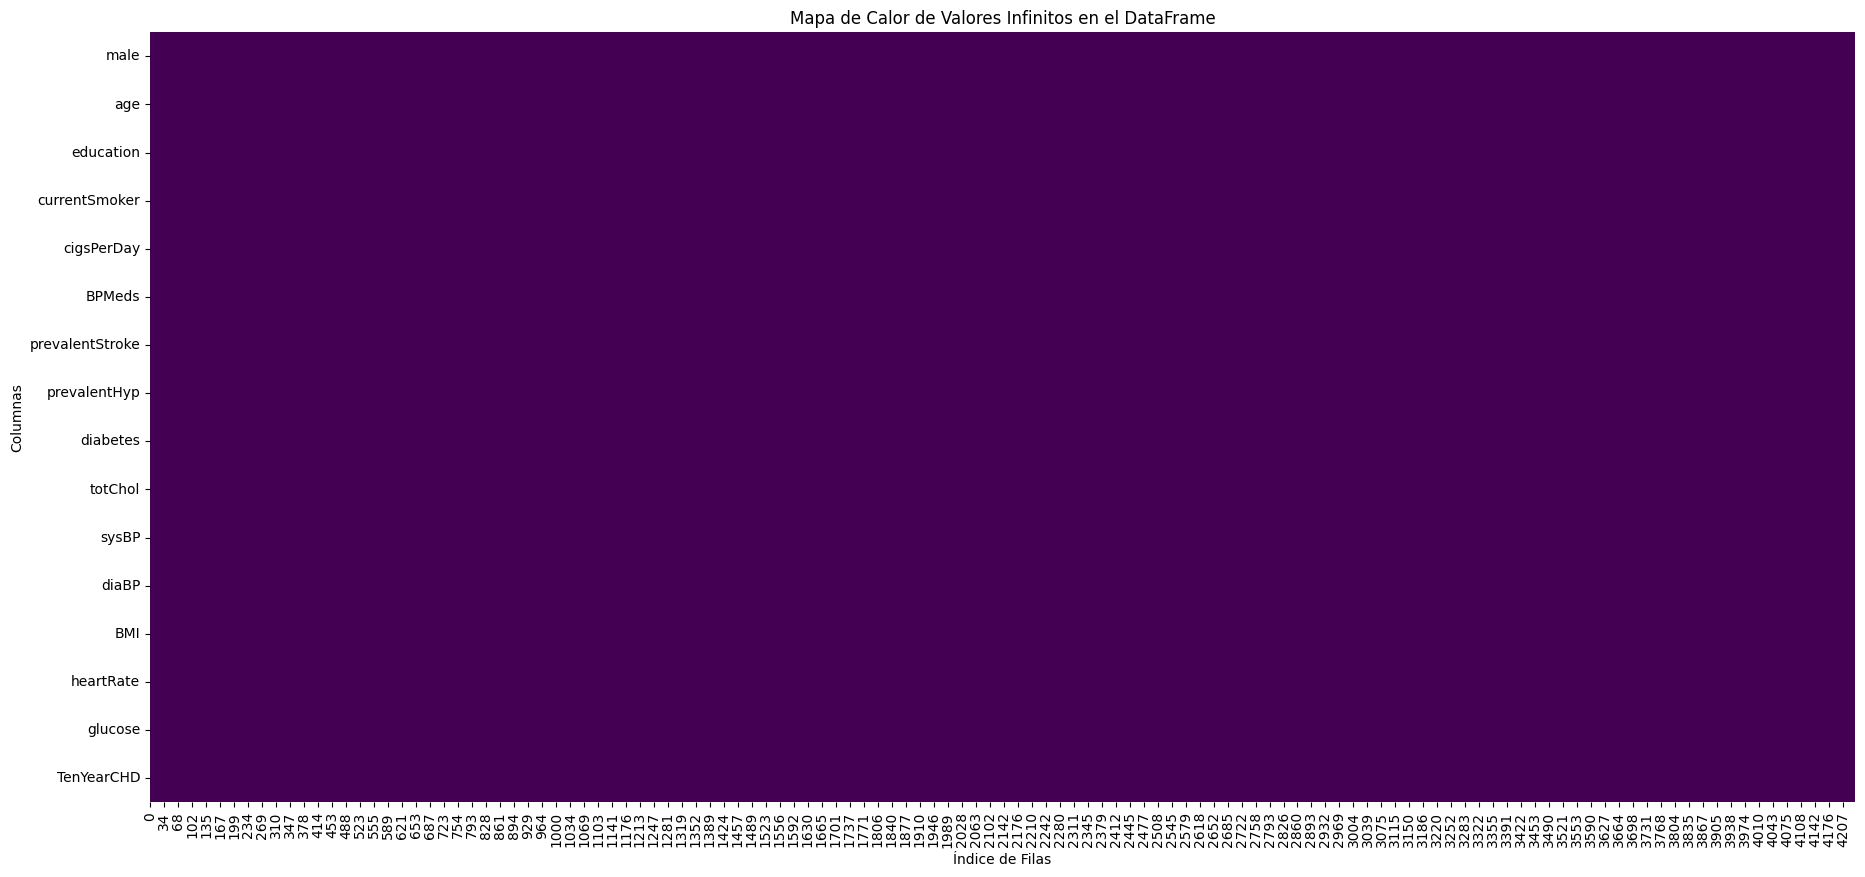

In [ ]:
# Crear una máscara de valores infinitos
inf_mask = np.isinf(framingham)

# Usar seaborn para crear un mapa de calor de los valores infinitos
plt.figure(figsize=(22, 10))  # Ajusta el tamaño de la figura según necesites
sns.heatmap(inf_mask.T, cbar=False, cmap='viridis', vmin=0, vmax=1)
plt.title('Mapa de Calor de Valores Infinitos en el DataFrame')
plt.xlabel('Índice de Filas')
plt.ylabel('Columnas')
plt.show()

In [ ]:
framingham["age_factor"] = pd.qcut(framingham["age"], q=4)

In [ ]:
framingham_with_dummies = create_dummies(framingham)
framingham_with_dummies.drop("age", axis=1, inplace=True)

### Selección de variables

In [ ]:
# Definir variables predictoras (X) y variable objetivo (Y)
Y = framingham_with_dummies.loc[:, framingham_with_dummies.columns == y]
X = framingham_with_dummies.loc[:, framingham_with_dummies.columns != y]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
# Creamos un remuestreo para que la variable objetivo esté igualmente proporcionada
over_sample = SMOTE(random_state=0)
os_X, os_Y = over_sample.fit_resample(X_train, Y_train)
os_X = pd.DataFrame(data=os_X, columns=X_train.columns)
os_Y = pd.DataFrame(data=os_Y, columns=[y])

# Podemos revisar los siguientes valores
print("Longitud de la data después del oversample", len(os_X))
print("Número de ceros en la variable objetivo", len(os_Y[os_Y[y]==0]))
print("Número de ceros en la variable objetivo", len(os_Y[os_Y[y]==1]))
print("Proporción de ceros en la variable objetivo", len(os_Y[os_Y[y]==0])/len(os_X))
print("Proporción de ceros en la variable objetivo", len(os_Y[os_Y[y]==1])/len(os_X))

Longitud de la data después del oversample 4352
Número de ceros en la variable objetivo 2176
Número de ceros en la variable objetivo 2176
Proporción de ceros en la variable objetivo 0.5
Proporción de ceros en la variable objetivo 0.5


In [ ]:
framingham_with_dummies = pd.concat([os_X, os_Y], axis=1)

In [ ]:
# Features
rfe = RFE(estimator=LogisticRegression())
rfe.fit(os_X, os_Y.values.ravel())

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

RFE(estimator=LogisticRegression())

In [ ]:
representativas = os_X.columns[rfe.support_]

In [ ]:
print(len(representativas), "variables representativas")

8 variables representativas


In [ ]:
representativas

Index(['male', 'currentSmoker', 'BPMeds', 'prevalentHyp', 'diabetes',
       'age_factor_(31.999, 42.0]', 'age_factor_(42.0, 49.0]',
       'age_factor_(49.0, 56.0]'],
      dtype='object')

### Modelo

In [ ]:
X = os_X.loc[:, representativas]
Y = os_Y

In [ ]:
# División del conjunto de datos en subconjuntos de entrenamiento y prueba con una proporción de 70/30
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [ ]:
logit_model = sm.Logit(Y, X) # statmodels

result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.521146
         Iterations 6
                              Results: Logit
Model:                  Logit               Method:              MLE      
Dependent Variable:     TenYearCHD          Pseudo R-squared:    0.248    
Date:                   2024-05-05 05:22    AIC:                 4552.0556
No. Observations:       4352                BIC:                 4603.0828
Df Model:               7                   Log-Likelihood:      -2268.0  
Df Residuals:           4344                LL-Null:             -3016.6  
Converged:              1.0000              LLR p-value:         0.0000   
No. Iterations:         6.0000              Scale:               1.0000   
--------------------------------------------------------------------------
                           Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
male                       0

In [ ]:
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

conf_matrix = confusion_matrix(Y_test, Y_pred)

TP = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TN = conf_matrix[1, 1]

accuracy = (TP+TN)/(TP+FP+FN+TN)

print(conf_matrix)

print("Precisión del modelo:", accuracy.round(4))

print(classification_report(Y_test, Y_pred))

[[507 144]
 [136 519]]
Precisión del modelo: 0.7856
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       651
           1       0.78      0.79      0.79       655

    accuracy                           0.79      1306
   macro avg       0.79      0.79      0.79      1306
weighted avg       0.79      0.79      0.79      1306



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


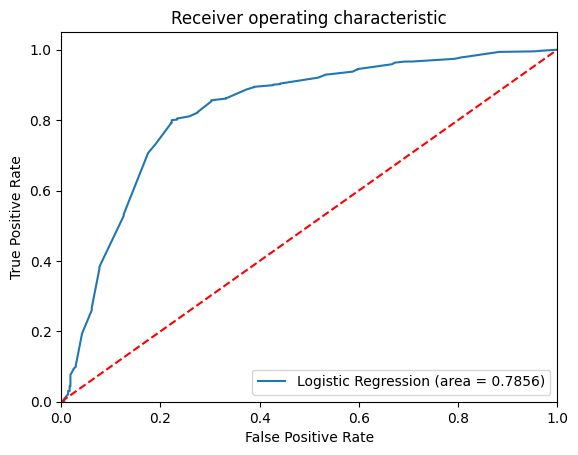

In [ ]:
logit_roc_auc = roc_auc_score(Y_test, logreg.predict(X_test))

fpr, tpr, thresholds = roc_curve(Y_test, logreg.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.4f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')

plt.show()

##  Conclusión

Es útil distribuir la edad en factores de forma equitativa para mejorar el modelo así como realizar un remuestreo del subconjunto que utilizamos como entrenamiento del modelo para ajustar nuestra variable objetivo y obtener una proporción de 50% para cada observación.

El valor de la Pseudo R-cuadrada podría ser pequeño en el dataset de scoring debido a la cantidad de valores atípicos en los datos.

Por lo cual se sugiere un tratamiento a los datos ya que si decidimos eliminarlos podríamos correr el riesgo de quedarnos con menos de la mitad de información.

En resumen con este trabajo y el análisis de los datos reforzamos los aspectos de la regresión logística.